# Evaluate Experiments

# Experiment 1: Impact of Subsidy Treaty vs Tax Treaty without breakdowns

Under various perturbations to costs, interest rate and marginal damages.

In [42]:
import os, torch, sys
from tqdm.auto import tqdm
import pandas as pd
%cd /scratch/users/metzgerj/github/subsidytreaties/code
data = dict(
    tax=[], generator_subsidy=[], battery_subsidy=[], step=[], n_counterfactuals=[],
    welfare=[], welfare_USA=[], welfare_CHN=[], welfare_EU=[], welfare_IND=[], 
    p_breakdown=[], value_at_risk=[], uniform=[], contiguous=[], delay=[], seed=[],
    dcumco2pct_USA=[], dcumco2pct_CHN=[], dcumco2pct_EU=[], dcumco2pct_IND=[],
    dcumco2abs_USA=[], dcumco2abs_CHN=[], dcumco2abs_EU=[], dcumco2abs_IND=[],
    cumco2=[], price_USA=[], price_CHN=[], price_EU=[], price_IND=[],
    deficit_to_GDP_USA=[], deficit_to_GDP_CHN=[], deficit_to_GDP_EU=[], deficit_to_GDP_IND=[],
    debt_to_GDP_USA=[], debt_to_GDP_CHN=[], debt_to_GDP_EU=[], debt_to_GDP_IND=[],
    maxdebt_to_GDP_USA=[], maxdebt_to_GDP_CHN=[], maxdebt_to_GDP_EU=[], maxdebt_to_GDP_IND=[],
)
folder = "results_sensitivity"
with torch.no_grad():
    for path in tqdm([_ for _ in os.listdir(folder) if _.startswith("run_")]):
        try:
            tax  = float(path.split("_")[1].strip('tax'))
            gsub = float(path.split("_")[2].strip('gsub'))
            bsub = float(path.split("_")[3].strip('bsub'))
            p_breakdown = float(path.split("_")[4].strip('p'))
            n_counterfactuals = int(path.split("_")[5].strip('n'))
            delay = int(path.split("_")[6].strip('delay'))
            value_at_risk = float(path.split("_")[7].strip('valueatrisk'))
            uniform = path.split("_")[8].strip('uniform') == "True"
            contiguous = path.split("_")[9].strip('contiguous') == "True"
            seed = int(path.split("_")[-1].strip('seed'))
            sys.argv = [
                "Simulate.ipy", f"--tax={tax}", f"--generator_subsidy={gsub}", f"--battery_subsidy={bsub}", 
                f"--folder={folder}", f"--eval=1", f"--p_breakdown={p_breakdown}", f"--n_counterfactuals={n_counterfactuals}", 
                f"--value_at_risk={value_at_risk}", f"--delay={delay}", f"--seed={seed}"
            ] + ["--contiguous=1"] * contiguous + ["--uniform=1"] * uniform
            %run Simulate.ipy
            npv = (likelihood*discount*(v/v[0:1].detach()-1)*I_bau)[1:, :].sum([0,2,3,4]).cpu()/bnUSD/1000
            cumco2 = (likelihood*(e_Q * Q).sum([1,2,4], keepdim=True).cumsum(3)/(e_Q * Q[0:1]).sum([1,2,4], keepdim=True).cumsum(3))[1:,0,0,:,0].sum(0).cpu()
            cumco2_i = (likelihood*(e_Q * Q)).sum([2,3,4])[1:,:].sum(0).cpu()
            cumco2_BAU = (e_Q * Q[0:1]).sum([0,2,3,4]).cpu()
            debt_to_gdp = (likelihood * discount * B)[1:].sum([0,2,4]).cumsum(-1)/(likelihood*discount*I)[1:].sum([0,2,4])
            deficit_to_gdp = (likelihood * B)[1:].sum([0,2,4])/(likelihood*I)[1:].sum([0,2,4])
            p_avg = ((likelihood*P_CES(p))[1:]/P_CES(p)[0:1])[:,:,0,:,0].sum(0).mean(-1).cpu()
            data["welfare"].append(npv.sum().item())
            data["welfare_USA"].append(npv[0].item())
            data["welfare_CHN"].append(npv[1].item())
            data["welfare_EU"].append(npv[2].item())
            data["welfare_IND"].append(npv[3].item())
            data["cumco2"].append(cumco2.tolist())
            data["dcumco2pct_USA"].append((cumco2_i[0].item()/cumco2_BAU[0].item()-1)*100)
            data["dcumco2pct_CHN"].append((cumco2_i[1].item()/cumco2_BAU[1].item()-1)*100)
            data["dcumco2pct_EU"].append((cumco2_i[2].item()/cumco2_BAU[2].item()-1)*100)
            data["dcumco2pct_IND"].append((cumco2_i[3].item()/cumco2_BAU[3].item()-1)*100)
            data["dcumco2abs_USA"].append(cumco2_i[0].item()-cumco2_BAU[0].item())
            data["dcumco2abs_CHN"].append(cumco2_i[1].item()-cumco2_BAU[1].item())
            data["dcumco2abs_EU"].append(cumco2_i[2].item()-cumco2_BAU[2].item())
            data["dcumco2abs_IND"].append(cumco2_i[3].item()-cumco2_BAU[3].item())
            data["debt_to_GDP_USA"].append(debt_to_gdp[0].tolist())
            data["debt_to_GDP_CHN"].append(debt_to_gdp[1].tolist())
            data["debt_to_GDP_EU"].append(debt_to_gdp[2].tolist())
            data["debt_to_GDP_IND"].append(debt_to_gdp[3].tolist())
            data["deficit_to_GDP_USA"].append(deficit_to_gdp[0].tolist())
            data["deficit_to_GDP_CHN"].append(deficit_to_gdp[1].tolist())
            data["deficit_to_GDP_EU"].append(deficit_to_gdp[2].tolist())
            data["deficit_to_GDP_IND"].append(deficit_to_gdp[3].tolist())
            data["maxdebt_to_GDP_USA"].append(debt_to_gdp[0].max().item())
            data["maxdebt_to_GDP_CHN"].append(debt_to_gdp[1].max().item())
            data["maxdebt_to_GDP_EU"].append(debt_to_gdp[2].max().item())
            data["maxdebt_to_GDP_IND"].append(debt_to_gdp[3].max().item())
            data["price_USA"].append(p_avg[0].item())
            data["price_CHN"].append(p_avg[1].item())
            data["price_EU"].append(p_avg[2].item())
            data["price_IND"].append(p_avg[3].item())
            data["step"].append(first_step)
            data["tax"].append(tax)
            data["generator_subsidy"].append(gsub)
            data["battery_subsidy"].append(bsub)
            data["n_counterfactuals"].append(n_counterfactuals)
            data["p_breakdown"].append(p_breakdown)
            data["uniform"].append(uniform)
            data["contiguous"].append(contiguous)
            data["delay"].append(delay)
            data["seed"].append(seed)
            data["value_at_risk"].append(value_at_risk)
            del B, T, I, scc, B_, K_, Q_, v, discount, e_Q, dT_de, T_bau, npv, profit
        except Exception as e:
            print("! error with ", path)
data = pd.DataFrame(data)
data.sort_values("welfare", ascending=False).to_pickle(f"{folder}/results.pkl")

/scratch/users/metzgerj/github/subsidytreaties/code


  0%|          | 0/1495 [00:00<?, ?it/s]

Namespace(folder='results_sensitivity', tax=0.0, generator_subsidy=0.8, battery_subsidy=0.0, p_breakdown=0.001, n_counterfactuals=2, delay=4, value_at_risk=0.0, uniform=False, contiguous=True, seed=244, eval=True, n_steps=200000)
writing to results_sensitivity/run_tax0.0_gsub0.8_bsub0.0_p0.001_n2_delay4_valueatrisk0.0_uniformFalse_contiguousTrue_seed244/log.txt
resuming checkpoint from step 200000...
Namespace(folder='results_sensitivity', tax=1.0, generator_subsidy=0.0, battery_subsidy=0.0, p_breakdown=0.001, n_counterfactuals=2, delay=4, value_at_risk=0.0, uniform=False, contiguous=True, seed=395, eval=True, n_steps=200000)
writing to results_sensitivity/run_tax1.0_gsub0.0_bsub0.0_p0.001_n2_delay4_valueatrisk0.0_uniformFalse_contiguousTrue_seed395/log.txt
resuming checkpoint from step 200000...
Namespace(folder='results_sensitivity', tax=0.0, generator_subsidy=0.99, battery_subsidy=0.0, p_breakdown=0.001, n_counterfactuals=2, delay=4, value_at_risk=0.0, uniform=False, contiguous=True

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

! error with  results_sensitivity/run_tax1.0_gsub0.0_bsub0.0_p0.001_n2_delay4_valueatrisk0.0_uniformFalse_contiguousTrue_seed377
Namespace(folder='results_sensitivity', tax=0.0, generator_subsidy=0.99, battery_subsidy=0.0, p_breakdown=0.001, n_counterfactuals=2, delay=4, value_at_risk=0.0, uniform=False, contiguous=True, seed=255, eval=True, n_steps=200000)
writing to results_sensitivity/run_tax0.0_gsub0.99_bsub0.0_p0.001_n2_delay4_valueatrisk0.0_uniformFalse_contiguousTrue_seed255/log.txt
resuming checkpoint from step 200000...
Namespace(folder='results_sensitivity', tax=0.0, generator_subsidy=0.99, battery_subsidy=0.0, p_breakdown=0.001, n_counterfactuals=2, delay=4, value_at_risk=0.0, uniform=False, contiguous=True, seed=361, eval=True, n_steps=200000)
writing to results_sensitivity/run_tax0.0_gsub0.99_bsub0.0_p0.001_n2_delay4_valueatrisk0.0_uniformFalse_contiguousTrue_seed361/log.txt
resuming checkpoint from step 200000...
Namespace(folder='results_sensitivity', tax=0.0, generator_

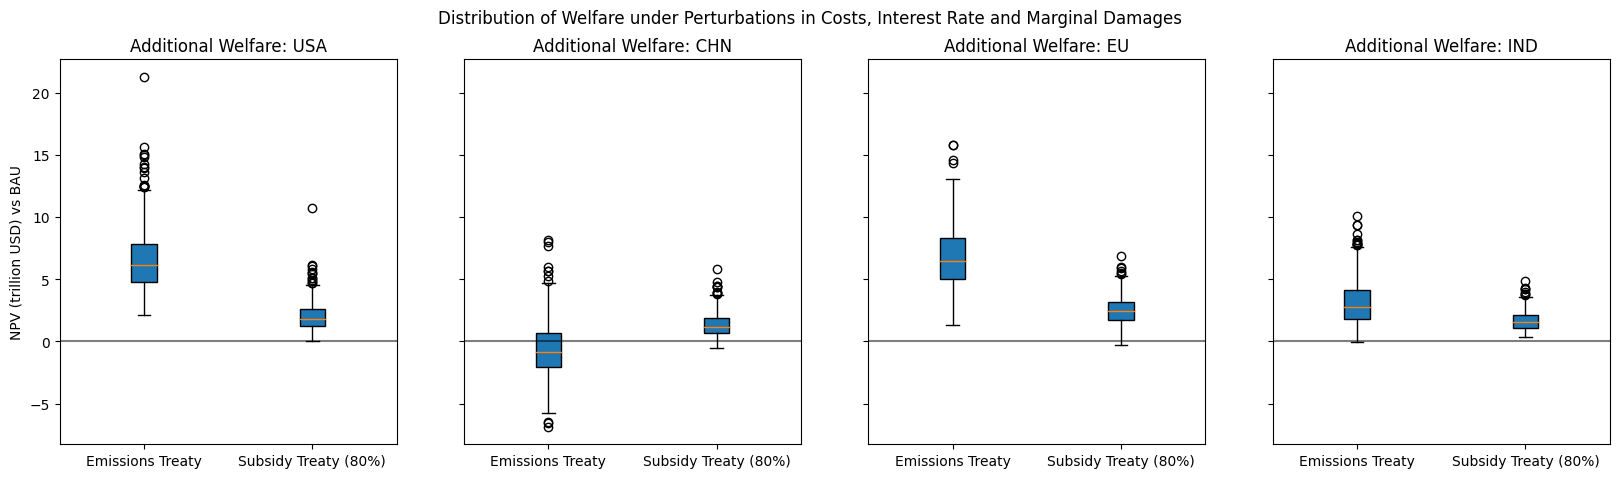

In [43]:
# boxplot of welfare within countries
data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
)

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

countries = ["USA", "CHN", "EU", "IND"]
for i, country in enumerate(countries):
    positions = [1, 2]
    data_tax = data.query('tax>0')[f'welfare_{country}']
    #data_subsidy = data.query('generator_subsidy>0.9')[f'welfare_{country}']
    data_subsidy = data.query('generator_subsidy==0.8')[f'welfare_{country}']
    ax[i].boxplot([data_tax, data_subsidy], positions=positions, vert=True, patch_artist=True)
    ax[i].axhline(0, color='black', linestyle='-', alpha=0.5)
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(['Emissions Treaty', 'Subsidy Treaty (80%)'])
    ax[i].set_title(f'Additional Welfare: {country}')
    if i == 0:
        ax[i].set_ylabel('NPV (trillion USD) vs BAU')

fig.suptitle('Distribution of Welfare under Perturbations in Costs, Interest Rate and Marginal Damages')
plt.savefig("figures/welfare_boxplot.png")
plt.show()

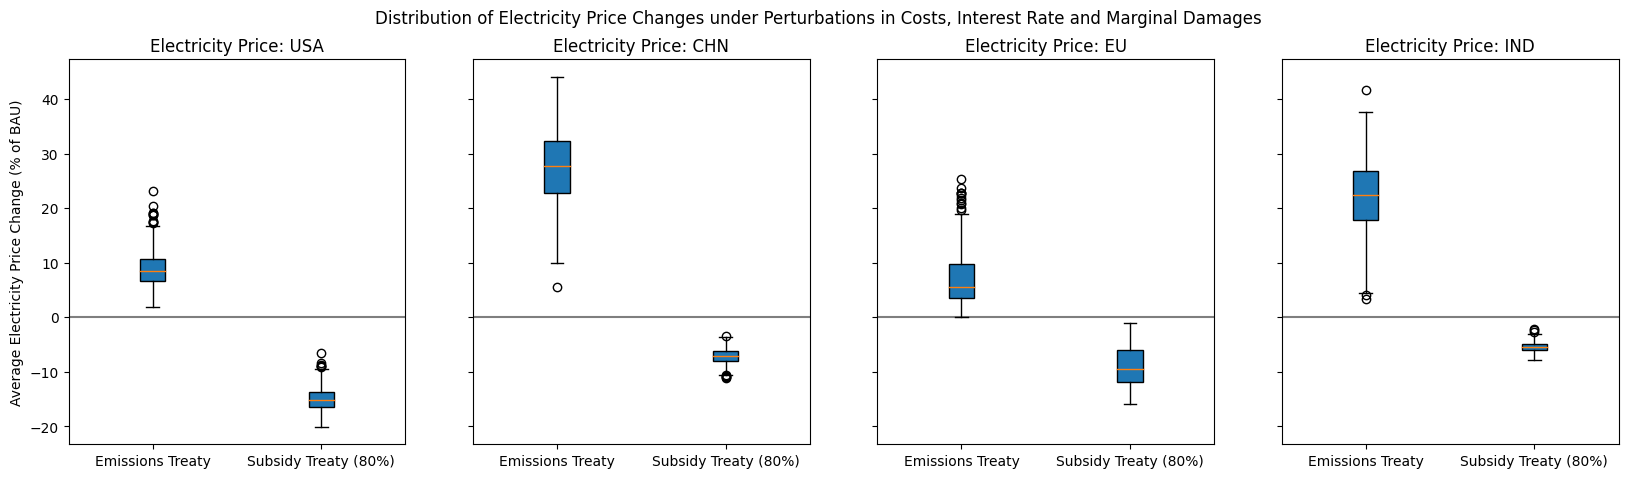

In [44]:
# boxplot of welfare within countries
data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
)

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

countries = ["USA", "CHN", "EU", "IND"]
for i, country in enumerate(countries):
    positions = [1, 2]
    data_tax = (data.query('tax>0')[f'price_{country}']-1)*100
    data_subsidy = (data.query('generator_subsidy==0.8')[f'price_{country}']-1)*100
    ax[i].boxplot([data_tax, data_subsidy], positions=positions, vert=True, patch_artist=True)
    ax[i].axhline(0, color='black', linestyle='-', alpha=0.5)
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(['Emissions Treaty', 'Subsidy Treaty (80%)'])
    ax[i].set_title(f'Electricity Price: {country}')
    if i == 0:
        ax[i].set_ylabel('Average Electricity Price Change (% of BAU)')

fig.suptitle('Distribution of Electricity Price Changes under Perturbations in Costs, Interest Rate and Marginal Damages')
plt.savefig("figures/price_boxplot.png")
plt.show()

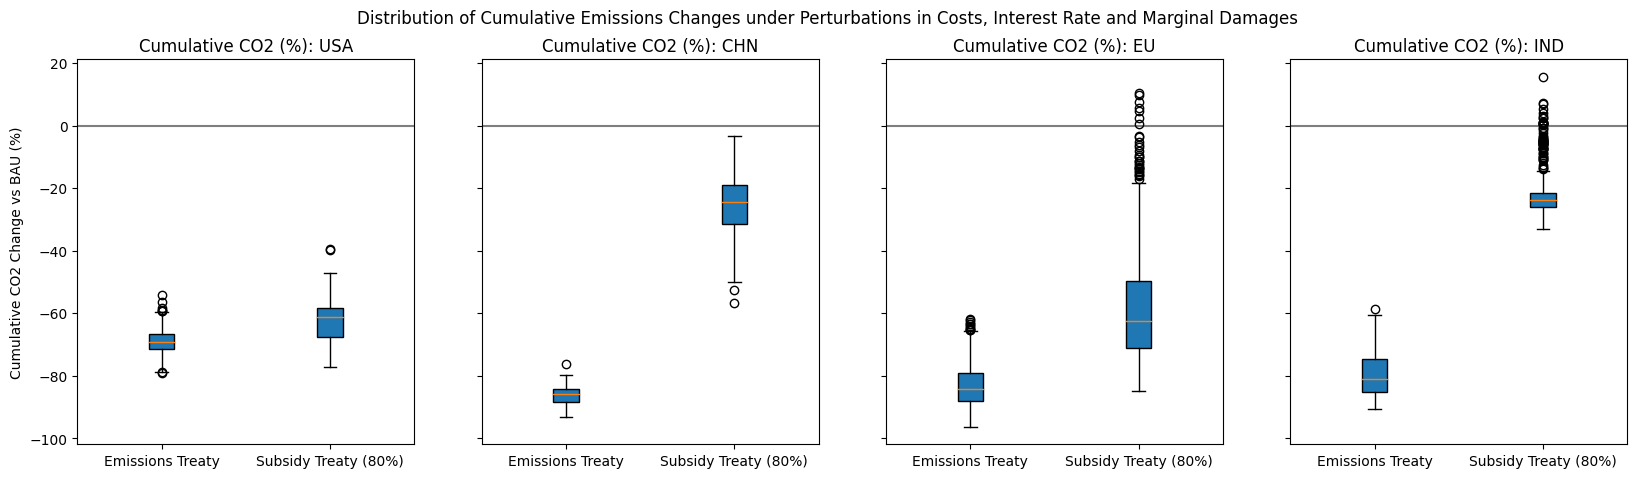

In [45]:
# boxplot of welfare within countries
data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
)

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

countries = ["USA", "CHN", "EU", "IND"]
for i, country in enumerate(countries):
    positions = [1, 2]
    data_tax = data.query('tax>0')[f'dcumco2pct_{country}']
    data_subsidy = data.query('generator_subsidy==0.8')[f'dcumco2pct_{country}']
    ax[i].boxplot([data_tax, data_subsidy], positions=positions, vert=True, patch_artist=True)
    ax[i].axhline(0, color='black', linestyle='-', alpha=0.5)
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(['Emissions Treaty', 'Subsidy Treaty (80%)'])
    ax[i].set_title(f'Cumulative CO2 (%): {country}')
    if i == 0:
        ax[i].set_ylabel('Cumulative CO2 Change vs BAU (%)')

fig.suptitle('Distribution of Cumulative Emissions Changes under Perturbations in Costs, Interest Rate and Marginal Damages')
plt.savefig("figures/cumco2_boxplot.png")
plt.show()

/scratch/users/metzgerj/github/subsidytreaties/code


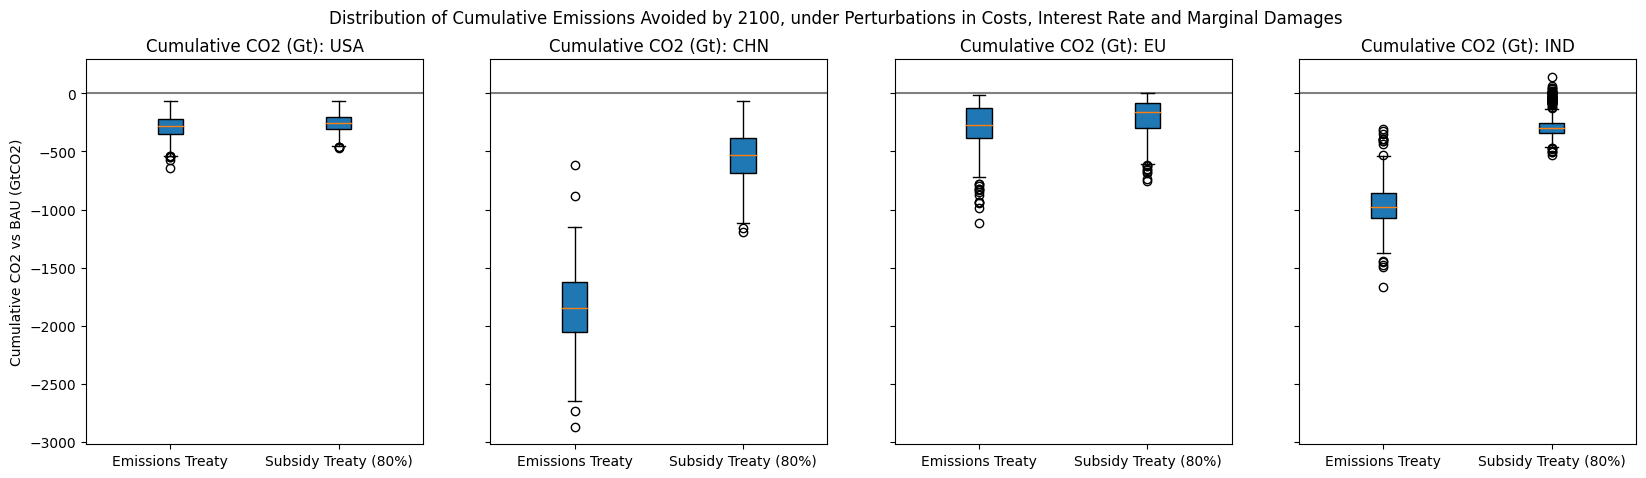

In [46]:
# boxplot of welfare within countries
import pandas as pd
from matplotlib import pyplot as plt
%cd /scratch/users/metzgerj/github/subsidytreaties/code
data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
)

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

countries = ["USA", "CHN", "EU", "IND"]
for i, country in enumerate(countries):
    positions = [1, 2]
    data_tax = data.query('tax>0')[f'dcumco2abs_{country}']
    data_subsidy = data.query('generator_subsidy==0.80')[f'dcumco2abs_{country}']
    ax[i].boxplot([data_tax, data_subsidy], positions=positions, vert=True, patch_artist=True)
    ax[i].axhline(0, color='black', linestyle='-', alpha=0.5)
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(['Emissions Treaty', 'Subsidy Treaty (80%)'])
    ax[i].set_title(f'Cumulative CO2 (Gt): {country}')
    if i == 0:
        ax[i].set_ylabel('Cumulative CO2 vs BAU (GtCO2)')

fig.suptitle('Distribution of Cumulative Emissions Avoided by 2100, under Perturbations in Costs, Interest Rate and Marginal Damages')
plt.savefig("figures/cumco2abs_boxplot.png")
plt.show()

/scratch/users/metzgerj/github/subsidytreaties/code


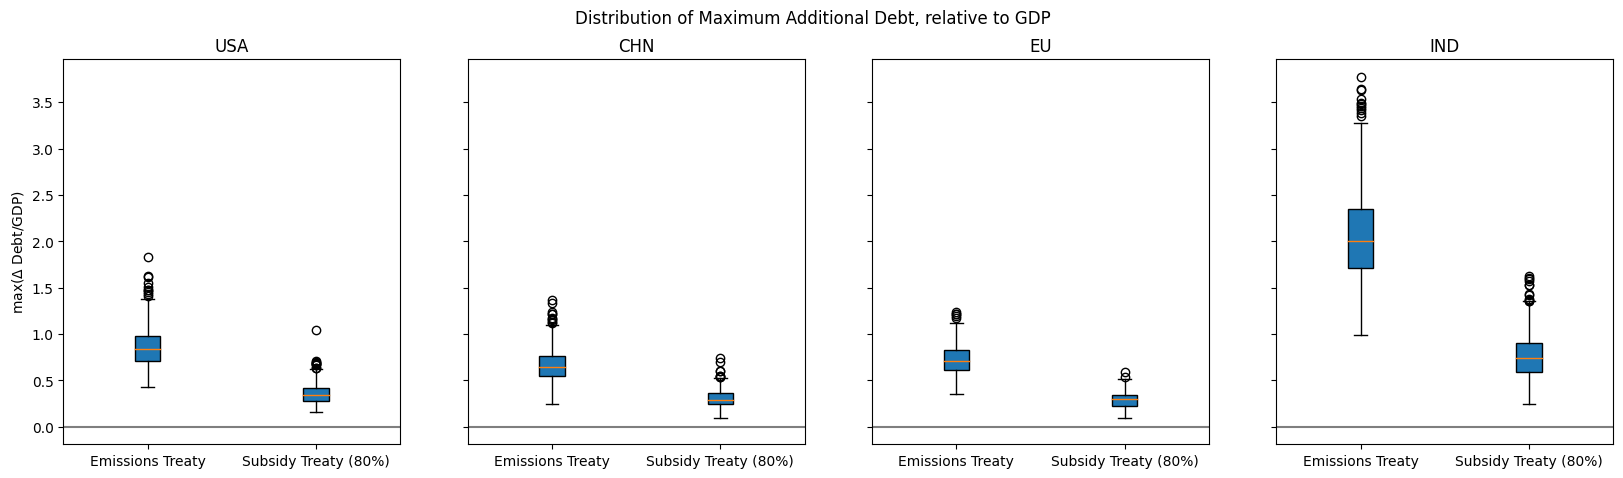

In [47]:
# boxplot of welfare within countries
import pandas as pd
from matplotlib import pyplot as plt
%cd /scratch/users/metzgerj/github/subsidytreaties/code
data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
)

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

countries = ["USA", "CHN", "EU", "IND"]
for i, country in enumerate(countries):
    positions = [1, 2]
    data_tax = data.query('tax>0')[f'maxdebt_to_GDP_{country}']
    data_subsidy = data.query('generator_subsidy==0.80')[f'maxdebt_to_GDP_{country}']
    ax[i].boxplot([data_tax, data_subsidy], positions=positions, vert=True, patch_artist=True)
    ax[i].axhline(0, color='black', linestyle='-', alpha=0.5)
    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(['Emissions Treaty', 'Subsidy Treaty (80%)'])
    ax[i].set_title(country)
    if i == 0:
        ax[i].set_ylabel('max($\Delta$ Debt/GDP)')

fig.suptitle('Distribution of Maximum Additional Debt, relative to GDP')
#plt.savefig("figures/cumco2abs_boxplot.png")
plt.show()

/scratch/users/metzgerj/github/subsidytreaties/code


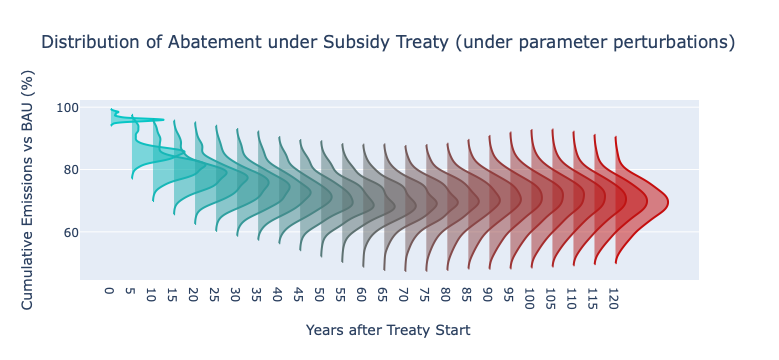

In [56]:
import plotly.graph_objects as go

import plotly as py
from plotly.colors import n_colors
import pandas as pd
import numpy as np

%cd /scratch/users/metzgerj/github/subsidytreaties/code

delay = 4

data = (pd
 .read_pickle(f"results_sensitivity/results.pkl")
 .query('step == step.max()')
 .query('generator_subsidy==0.8')
 .explode('cumco2')
 .assign(Year=lambda x: x.groupby(['seed']).cumcount()-delay)
 .query('Year>=0')
 .sort_values("Year")
 .set_index("Year")
 .groupby('seed')
 .cumco2
)

data = np.array([s for (_, s) in data]).T * 100
colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', data.shape[0], colortype='rgb')
labels = [f"Year {i}" for i in range(data.shape[0])]
fig = go.Figure()
for data_line, color, label in zip(data, colors, range(data.shape[0])):
    if label % 5 != 1: continue
    fig.add_trace(go.Violin(y=data_line, line_color=color, name=label-1))

fig.update_traces(orientation='v', side='positive', width=5, points=False)
fig.update_layout(xaxis_tickmode='linear', xaxis_tick0=0, xaxis_dtick=1)
fig.update_layout(showlegend=False)
fig.update_layout(
    title={
        'text': r"Distribution of Abatement under Subsidy Treaty (under parameter perturbations)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="Cumulative Emissions vs BAU (%)",
    xaxis_title="Years after Treaty Start"
)
fig.show(figsize=(1000, 500))
fig.write_image("figures/abatement_ridgeplot.png", width=1000, height=500)

/scratch/users/metzgerj/github/subsidytreaties/code


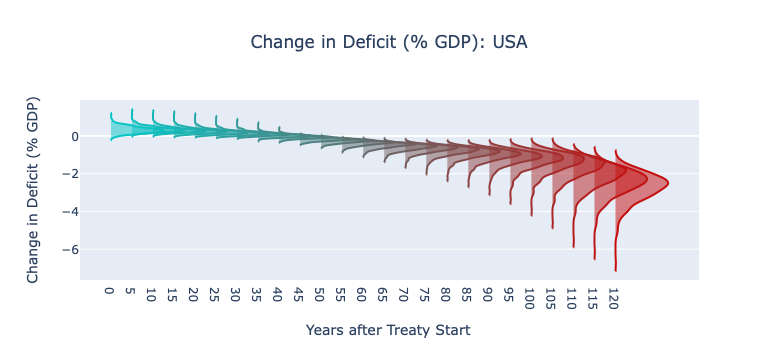

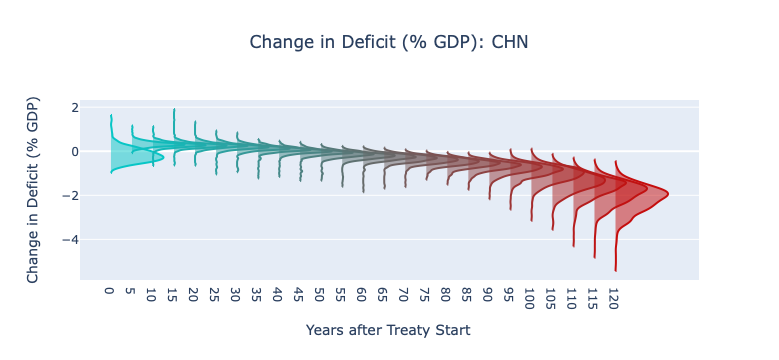

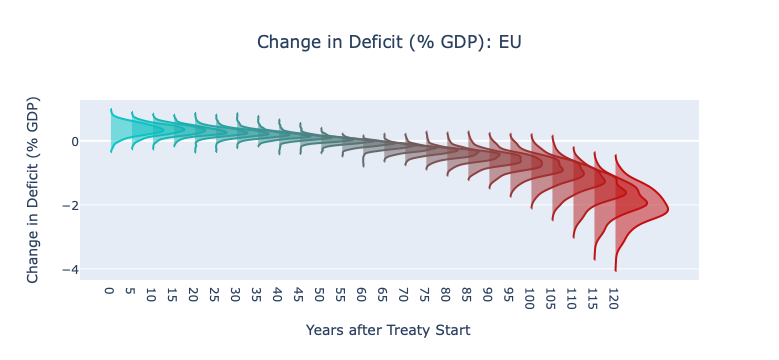

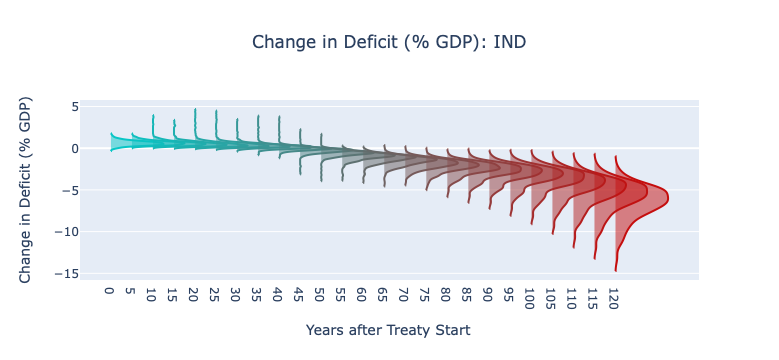

In [60]:
import plotly.graph_objects as go

import plotly as py
from plotly.colors import n_colors
import pandas as pd
import numpy as np

%cd /scratch/users/metzgerj/github/subsidytreaties/code

for country in ["USA", "CHN", "EU", "IND"]:
    data = (pd
     .read_pickle(f"results_sensitivity/results.pkl")
     .query('step == step.max()')
     .query('generator_subsidy==0.8')
     .explode(f'deficit_to_GDP_{country}')
     .assign(Year=lambda x: x.groupby(['seed']).cumcount()-delay)
     .query('Year>=0')
     .sort_values("Year")
     .set_index("Year")
     .groupby('seed')[f'deficit_to_GDP_{country}']
    )
    
    
    data = np.array([s for (_, s) in data]).T * 100
    colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', data.shape[0], colortype='rgb')
    labels = [f"Year {i}" for i in range(data.shape[0])]
    fig = go.Figure()
    for data_line, color, label in zip(data, colors, range(data.shape[0])):
        if label % 5 != 1:
            continue
        fig.add_trace(go.Violin(y=data_line, line_color=color, name=label-1))
    
    fig.update_traces(orientation='v', side='positive', width=5, points=False)
    fig.update_layout(xaxis_tickmode='linear', xaxis_tick0=0, xaxis_dtick=1)
    fig.update_layout(showlegend=False)
    fig.update_layout(
        title={
            'text': f"Change in Deficit (% GDP): {country}",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        yaxis_title="Change in Deficit (% GDP)",
        xaxis_title="Years after Treaty Start"
    )
    fig.show(figsize=(1000, 500))
    fig.write_image(f"figures/deficit_{country}.png", width=1000, height=500)

# Experiment 2: Comparing Robustness to Breakdowns of Different Treaties

In [14]:
import os, torch, sys
from tqdm.auto import tqdm
import pandas as pd
%cd /scratch/users/metzgerj/github/subsidytreaties/code
data = dict(
    tax=[], generator_subsidy=[], battery_subsidy=[], step=[], n_counterfactuals=[],
    welfare=[], welfare_USA=[], welfare_CHN=[], welfare_EU=[], welfare_IND=[], 
    p_breakdown=[], value_at_risk=[], uniform=[], contiguous=[], delay=[], seed=[]
)
folder = "results_p_breakdown"
with torch.no_grad():
    for path in tqdm([_ for _ in os.listdir(folder) if _.startswith("run_")]):
        try:
            tax  = float(path.split("_")[1].strip('tax'))
            gsub = float(path.split("_")[2].strip('gsub'))
            bsub = float(path.split("_")[3].strip('bsub'))
            p_breakdown = float(path.split("_")[4].strip('p'))
            n_counterfactuals = int(path.split("_")[5].strip('n'))
            delay = int(path.split("_")[6].strip('delay'))
            value_at_risk = float(path.split("_")[7].strip('valueatrisk'))
            uniform = path.split("_")[8].strip('uniform') == "True"
            contiguous = path.split("_")[9].strip('contiguous') == "True"
            seed = int(path.split("_")[-1].strip('seed'))
            data["tax"].append(tax)
            data["generator_subsidy"].append(gsub)
            data["battery_subsidy"].append(bsub)
            data["n_counterfactuals"].append(n_counterfactuals)
            data["p_breakdown"].append(p_breakdown)
            data["uniform"].append(uniform)
            data["contiguous"].append(contiguous)
            data["delay"].append(delay)
            data["seed"].append(seed)
            data["value_at_risk"].append(value_at_risk)
            sys.argv = [
                "Simulate.ipy", f"--tax={tax}", f"--generator_subsidy={gsub}", f"--battery_subsidy={bsub}", 
                f"--folder={folder}", f"--eval=1", f"--p_breakdown={p_breakdown}", f"--n_counterfactuals={n_counterfactuals}", 
                f"--value_at_risk={value_at_risk}", f"--delay={delay}", f"--seed={seed}"
            ] + ["--contiguous=1"] * contiguous + ["--uniform=1"] * uniform
            %run Simulate.ipy
            npv = (likelihood*discount*(v/v[0:1].detach()-1)*I_bau)[:, :].sum([0,2,3,4]).cpu()/bnUSD/1000
            data["welfare"].append(npv.sum().item())
            data["welfare_USA"].append(npv[0].item())
            data["welfare_CHN"].append(npv[1].item())
            data["welfare_EU"].append(npv[2].item())
            data["welfare_IND"].append(npv[3].item())
            data["step"].append(first_step)
            if n_counterfactuals > 50: break
            del B, T, I, scc, B_, K_, Q_, v, discount, e_Q, dT_de, T_bau, npv, profit
        except KeyboardInterrupt as e:
            print("! error with ", path, e)
            break
data = pd.DataFrame(data)
data.sort_values("welfare", ascending=False).to_csv(f"{folder}/varying_p_breakdown.csv", index=False)


/scratch/users/metzgerj/github/subsidytreaties/code


  0%|          | 0/72 [00:00<?, ?it/s]

Namespace(folder='results_p_breakdown', tax=0.0, generator_subsidy=0.8, battery_subsidy=0.0, p_breakdown=0.9, n_counterfactuals=64, delay=4, value_at_risk=0.0, uniform=True, contiguous=True, seed=0, eval=True, n_steps=200000)
writing to results_p_breakdown/run_tax0.0_gsub0.8_bsub0.0_p0.9_n64_delay4_valueatrisk0.0_uniformTrue_contiguousTrue_seed0/log.txt
resuming checkpoint from step 172000...


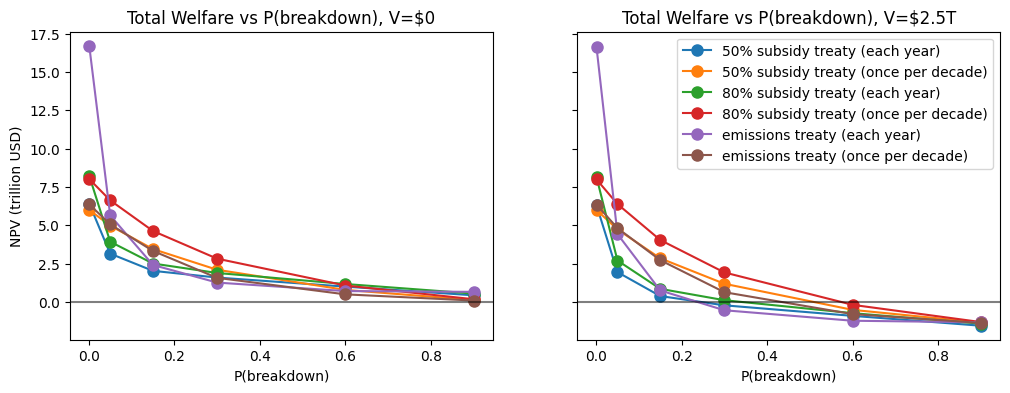

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

(pd.read_csv(f"results_p_breakdown/varying_p_breakdown.csv")
 .query("value_at_risk == 0.0")
 .sort_values('p_breakdown')
 .set_index('p_breakdown')
 .assign(policy=lambda x: np.where(x.tax>0, "emissions treaty", (x.generator_subsidy*100).astype(int).astype(str) +"% subsidy treaty") + np.where(x.n_counterfactuals == 64, ' (each year)', ' (once per decade)'))
 .groupby("policy")
 .welfare
 .plot(legend=False, ylabel="NPV (trillion USD)", title='Total Welfare vs P(breakdown), V=$0',  kind='line', marker='o', markersize=8, xlabel="P(breakdown)", ax=ax[0])
)
ax[0].axhline(0, color='black', linestyle='-', alpha=0.5)
ax[0].set_xlabel("P(breakdown)")
ax[0].set_ylabel("NPV (trillion USD)")
ax[0].set_title("Total Welfare vs P(breakdown), V=$0")

(pd.read_csv(f"results_p_breakdown/varying_p_breakdown.csv")
 .query("value_at_risk == 2.5")
 .sort_values('p_breakdown')
 .set_index('p_breakdown')
 .assign(policy=lambda x: np.where(x.tax>0, "emissions treaty", (x.generator_subsidy*100).astype(int).astype(str) +"% subsidy treaty") + np.where(x.n_counterfactuals == 64, ' (each year)', ' (once per decade)'))
 .groupby("policy")
 .welfare
 .plot(legend=True, ylabel="NPV (trillion USD)", title='Total Welfare vs P(breakdown), V=$2.5T',  kind='line', marker='o', markersize=8, xlabel="P(breakdown)", ax=ax[1])
)
ax[1].axhline(0, color='black', linestyle='-', alpha=0.5)
ax[1].set_xlabel("P(breakdown)")
ax[1].set_ylabel("NPV (trillion USD)")
ax[1].set_title("Total Welfare vs P(breakdown), V=$2.5T")


plt.savefig("figures/welfare_vs_p_breakdown.png", dpi=300)
#plt.show()
